## Topics Covered

* Text Vectorization for RNNs
* Word Embeddings indexing
* Text Classification with Neural Networks (RNNs)



## Import Libraries

In [ ]:
!pip install --upgrade gensim
# Restart Session
import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 490.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 16.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 r

In [1]:
!nvidia-smi

Wed May 21 15:30:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import re
import gensim.downloader as api
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups

## Assert whether ``PyTorch`` can use an available GPU card

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


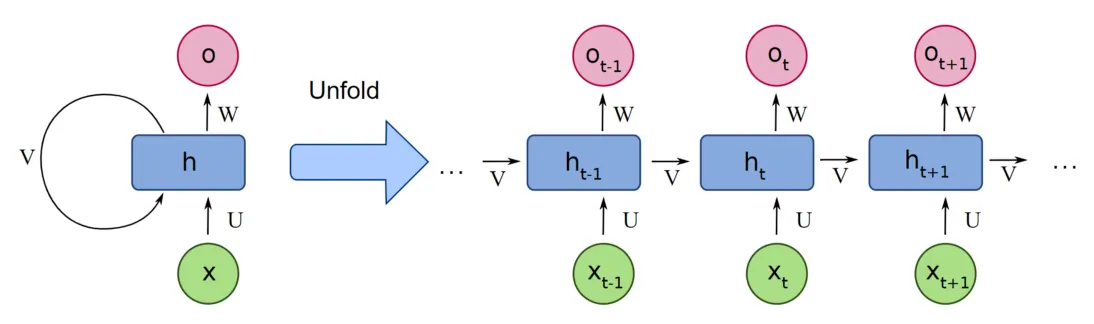

## Data Preprocessing

We will use the ``20newsgroups`` dataset. This is a single-label multi-class dataset with $20$ categories. We load and split the data into training and validation sets.

We will use integer encoding to represent each text and then match each integer (token) with a pre-trained ``Word2Vec`` embedding, initializing the embedding matrix $E$. We will keep the top 10000 tokens, based on frequency on the corpus.

We will also use the average length of the training split for padding the sequences to a predefined length.



In [11]:
# Load 20 Newsgroups dataset
# categories = ['comp.graphics', 'sci.space']
newsgroups_data = fetch_20newsgroups(subset='all',
                                     remove=('headers', 'footers', 'quotes'))
texts, labels = newsgroups_data.data, newsgroups_data.target

X_train, X_val, y_train, y_val = train_test_split(texts, labels, test_size=0.3, random_state=42)

print(f'Number of training examples: {len(X_train)}')
print(f'Categories: {np.unique(y_train)}')

avg_length = int(np.mean([len(re.sub(r'[^a-zA-Z]', ' ', text.lower()).split()) for text in X_train]))

print(f'Training corpus average text length: {avg_length}')

# Create custom vocabulary using CountVectorizer
vectorizer = CountVectorizer(max_features=10000)
vectorizer.fit(X_train)
custom_vocab = vectorizer.vocabulary_

# Load Word2Vec embeddings using gensim downloader
word2vec = api.load('word2vec-google-news-300')

# Map custom vocabulary to Word2Vec indices with 'PAD' and 'UNK' tokens
embedding_dim = 300
average_embedding = np.mean(word2vec.vectors, axis=0)  # average of all embeddings
vocab = {'__PAD__': 0, '__UNK__': 1}
vocab.update({word: idx + 2 for idx, word in enumerate(custom_vocab)})
embedding_matrix = np.zeros((len(vocab), embedding_dim))
embedding_matrix[0] = np.zeros(embedding_dim)  # PAD token embedding
embedding_matrix[1] = average_embedding  # UNK token embedding
for word, idx in vocab.items():
    if word in word2vec:
        embedding_matrix[idx] = word2vec[word]
    elif idx > 1:
        embedding_matrix[idx] = average_embedding

del word2vec

Number of training examples: 13192
Categories: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Training corpus average text length: 187


In [27]:
embedding_matrix[vocab['__UNK__']]

array([-2.25728611e-04, -1.01306627e-03, -1.04773864e-02,  3.14636230e-02,
        1.94908399e-03, -4.83569540e-02,  8.71036202e-03, -4.18831371e-02,
        2.51461826e-02,  4.58311923e-02,  1.26088806e-03, -1.75505376e-03,
       -2.50608157e-02,  4.20754105e-02, -4.06269804e-02,  2.94472519e-02,
        1.80458277e-02,  3.59841287e-02, -2.66128872e-02, -7.92622752e-03,
        2.70865131e-02,  4.24901256e-03,  5.27169220e-02,  1.93178728e-02,
        5.10774646e-03, -2.76226867e-02, -3.38717587e-02,  4.39997353e-02,
        1.32414782e-02, -4.49229591e-02, -3.05306613e-02, -4.27834578e-02,
        4.64673946e-03, -2.74249297e-02,  3.94795975e-03, -7.11372793e-02,
        3.72331291e-02,  7.20562087e-03,  3.08779557e-03,  8.44953489e-03,
       -8.02358240e-03, -2.38431450e-02,  4.02598381e-02,  5.37732914e-02,
       -4.63994108e-02, -7.93176889e-02, -4.39509153e-02, -1.62945110e-02,
        7.95037951e-03,  4.17706594e-02, -6.89574629e-02,  3.71620990e-02,
       -1.33652124e-03, -

## Creating a Dataset

We will use the ``Dataset`` class from ``PyTorch`` to handle the text data. We will pad the text sequences with $0$ to a pre-defined length (the average number of tokens in the training split).

In [20]:
# Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_length):
        self.texts = [self.tokenize(text, vocab, max_length) for text in texts]
        self.labels = labels

    def tokenize(self, text, vocab, max_length):
        text = text.lower().split()
        tokens = [vocab.get(word, vocab['__UNK__']) for word in text]
        if len(tokens) < max_length:
            tokens += [vocab['__PAD__']] * (max_length - len(tokens))
        else:
            tokens = tokens[:max_length]
        return tokens

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx]), torch.tensor(self.labels[idx])

train_dataset = TextDataset(X_train, y_train, vocab, avg_length)
val_dataset = TextDataset(X_val, y_val, vocab, avg_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [23]:
train_dataset[3]

(tensor([  1, 151,   1, 356, 357,  10, 208,  25,   5, 358,  25,   5,   1,   1,
           1,   9,  44,  25,   5, 361, 362,   1,   1,   1, 363, 364, 365, 160,
           5, 366,  54, 367,  20, 368, 134,   1,   1, 151, 152, 370,  19, 354,
         242,   5, 371, 372,  78, 197,   1,   5, 360,   1,  14, 374, 375, 376,
         377, 371, 372, 139, 227, 378, 279, 254,   1,  57, 256, 379, 374, 375,
          54, 105,  57, 380,  31, 381,  25,   1,   1,   9,  44, 113,   5,   1,
         385, 386,  78,   5, 387, 381,  19,   1,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0

In [35]:
X_train[3]

'I am a little confused on all of the models of the 88-89 bonnevilles.\nI have heard of the LE SE LSE SSE SSEI. Could someone tell me the\ndifferences are far as features or performance. I am also curious to\nknow what the book value is for prefereably the 89 model. And how much\nless than book value can you usually get them for. In other words how\nmuch are they in demand this time of year. I have heard that the mid-spring\nearly summer is the best time to buy.'

## Define the model

We will create a model class and parameterize our neural network with several choices

In [28]:
# Define RNN, GRU, and LSTM models with optional Global Max Pooling / Self-Attention
class RNNModel(nn.Module):
    def __init__(self, vocab_size,
                 embed_dim, hidden_dim, output_dim, attention_dim=None,
                 model_type='RNN',
                 pretrained=True, freeze=False,
                 num_layers=1, bidirectional=False,
                 use_pooling=False, use_attention=False, dropout_rate=0.3):
        super(RNNModel, self).__init__()
        self.use_pooling = use_pooling
        self.use_attention = use_attention
        self.attention_mlp = None
        self.bidirectional = bidirectional
        self.dropout = dropout_rate
        self.drop_en = nn.Dropout(self.dropout)
        scale = 2 if bidirectional else 1

        if self.use_pooling:
          assert not self.use_attention, "Cannot use pooling and attention at the same time"
        elif self.use_attention:
          assert not self.use_pooling, "Cannot use pooling and attention at the same time"
        if pretrained:
            self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0).from_pretrained(torch.tensor(embedding_matrix,
                                                                                                             dtype=torch.float32),
                                                                                                freeze=freeze)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        rnn_class = {'RNN': nn.RNN, 'GRU': nn.GRU, 'LSTM': nn.LSTM}[model_type]
        self.rnn = rnn_class(embed_dim, hidden_dim, batch_first=True,
                             num_layers=num_layers, bidirectional=bidirectional)
        self.fc = nn.Linear(scale * hidden_dim, output_dim)  # you can add a MLP head

        if self.use_attention:
          # Feel free to customize the Attention MLP
          assert attention_dim is not None, "Attention dimension must be specified"
          self.attention_mlp = torch.nn.Sequential(
              torch.nn.Linear(scale * hidden_dim, attention_dim),
              torch.nn.Tanh(),
              torch.nn.Linear(attention_dim, 1)
          )

    def forward(self, x):
        embedded = self.drop_en(self.embedding(x))

        output, _ = self.rnn(embedded)  # οutput from all states of final layer
        if self.use_pooling:
            pooled = torch.max(output, dim=1)[0]  # max along all states
            return self.fc(self.drop_en(pooled))
        elif self.use_attention:
            attention_weights = self.attention_mlp(output)  # (batch_size, sequence_length, 1)

            # give very large negative value to padding tokens to be zeroed-out by softmax

            padding_mask = (x == 0).unsqueeze(-1)  # (batch_size, sequence_length, 1)
            attention_weights -= 100000.0 * padding_mask.float()

            attention_weights = torch.softmax(attention_weights, dim=1)
            attention_output = torch.sum(output * attention_weights, dim=1)  # dot product
            return self.fc(attention_output)
        else:
            if self.bidirectional:
              # Concatenate last state of forward and backward rnns
              out_fw, out_bw = torch.chunk(output, 2, dim=2)
              out_cat = torch.cat((out_fw[:, -1, :], out_bw[:, 0, :]), 1)
              return self.fc(self.drop_en(out_cat))
            else:
              return self.fc(self.drop_en(output[:, -1, :]))  # last state

## Training and Evaluation scripts

We will define two functions which will train and evaluate our model

In [29]:
import os

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_model_path = None  # To keep track of the previous best model file

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for texts, labels in train_loader:
            optimizer.zero_grad()
            texts = texts.to(device)
            labels = labels.to(torch.long).to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for texts, labels in val_loader:
                texts = texts.to(device)
                labels = labels.to(torch.long).to(device)
                outputs = model(texts)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

        if epoch % 2 == 0:
            print(f'Epoch: {epoch:4.0f} / {epochs} | Training Loss: {train_loss / len(train_loader):.5f}, Validation Loss: {val_loss / len(val_loader):.5f}')

        # You can also add early stopping here...

        if (val_loss / len(val_loader)) < best_val_loss:
          best_val_loss = val_loss / len(val_loader)
          new_model_path = f'rnn_best_model_epoch_{epoch+1}.pth'

          # Delete the previous best model if it exists
          if best_model_path is not None:
              os.remove(best_model_path)

          # Save the new best model
          torch.save(model.state_dict(), new_model_path)
          best_model_path = new_model_path  # Update the best model path

          # load model later with model.load_state_dict(torch.load(path))

    return train_losses, val_losses

# Evaluation function
def evaluate_model(model, val_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for texts, labels in val_loader:
            texts = texts.to(device)
            preds = torch.argmax(model(texts), dim=1)  # argmax of predictions
            y_true.extend(labels.tolist())
            y_pred.extend(preds.tolist())
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return accuracy, precision, recall, f1

## Initialize models and compare...

We will compare a RNN with a GRU and a LSTM

Training RNN...
Epoch:    0 / 10 | Training Loss: 2.98340, Validation Loss: 2.96499
Epoch:    2 / 10 | Training Loss: 2.88091, Validation Loss: 2.81618
Epoch:    4 / 10 | Training Loss: 2.76519, Validation Loss: 3.00009
Epoch:    6 / 10 | Training Loss: 2.62803, Validation Loss: 3.01104
Epoch:    8 / 10 | Training Loss: 2.51878, Validation Loss: 2.93865
Training GRU...
Epoch:    0 / 10 | Training Loss: 2.98323, Validation Loss: 2.96744
Epoch:    2 / 10 | Training Loss: 2.89048, Validation Loss: 2.96130
Epoch:    4 / 10 | Training Loss: 2.77102, Validation Loss: 2.99597
Epoch:    6 / 10 | Training Loss: 2.63331, Validation Loss: 3.05460
Epoch:    8 / 10 | Training Loss: 2.63956, Validation Loss: 3.09446
Training BiLSTM_Att...
Epoch:    0 / 10 | Training Loss: 2.19545, Validation Loss: 1.57040
Epoch:    2 / 10 | Training Loss: 1.01355, Validation Loss: 1.28739
Epoch:    4 / 10 | Training Loss: 0.65057, Validation Loss: 1.38994
Epoch:    6 / 10 | Training Loss: 0.42367, Validation Loss: 1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training FrozenWord2Vec...
Epoch:    0 / 10 | Training Loss: 2.90759, Validation Loss: 2.63215
Epoch:    2 / 10 | Training Loss: 2.22201, Validation Loss: 1.95830
Epoch:    4 / 10 | Training Loss: 1.84775, Validation Loss: 1.71734
Epoch:    6 / 10 | Training Loss: 1.74918, Validation Loss: 1.62328
Epoch:    8 / 10 | Training Loss: 1.68147, Validation Loss: 1.56219
Training TrainableWord2Vec...
Epoch:    0 / 10 | Training Loss: 2.81237, Validation Loss: 2.42204
Epoch:    2 / 10 | Training Loss: 1.59290, Validation Loss: 1.48845
Epoch:    4 / 10 | Training Loss: 1.22609, Validation Loss: 1.36052
Epoch:    6 / 10 | Training Loss: 1.05306, Validation Loss: 1.34077
Epoch:    8 / 10 | Training Loss: 0.94196, Validation Loss: 1.34039
Training FrozenWord2Vec_Attention...
Epoch:    0 / 10 | Training Loss: 2.73705, Validation Loss: 2.42424
Epoch:    2 / 10 | Training Loss: 1.90206, Validation Loss: 1.78134
Epoch:    4 / 10 | Training Loss: 1.59771, Validation Loss: 1.58796
Epoch:    6 / 10 | Tra

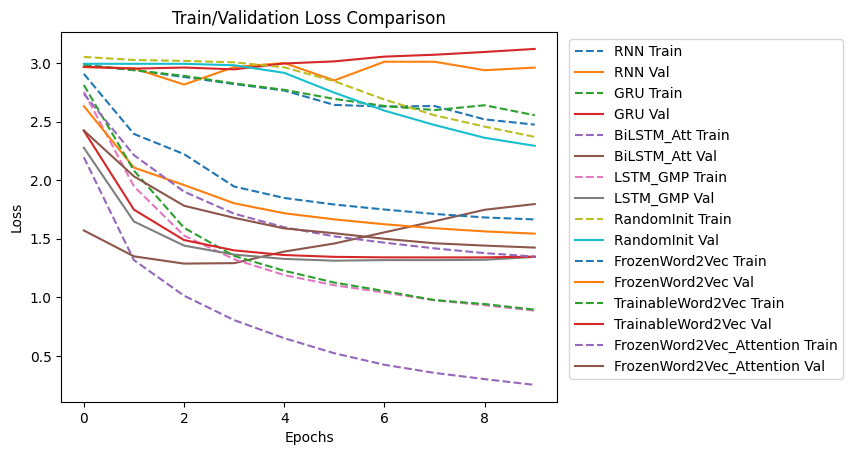

RNN: Accuracy=0.0918, Precision=0.0998, Recall=0.0942, F1=0.0563
GRU: Accuracy=0.0646, Precision=0.0738, Recall=0.0654, F1=0.0386
BiLSTM_Att: Accuracy=0.6143, Precision=0.6119, Recall=0.6046, F1=0.6060
LSTM_GMP: Accuracy=0.5990, Precision=0.6036, Recall=0.5866, F1=0.5875
RandomInit: Accuracy=0.3173, Precision=0.3267, Recall=0.3080, F1=0.3034
FrozenWord2Vec: Accuracy=0.5126, Precision=0.5325, Recall=0.4994, F1=0.4946
TrainableWord2Vec: Accuracy=0.5952, Precision=0.5912, Recall=0.5824, F1=0.5812
FrozenWord2Vec_Attention: Accuracy=0.5386, Precision=0.5304, Recall=0.5247, F1=0.5168


In [30]:
# Instantiate models and train

num_classes = len(np.unique(y_train))
models = {
    'RNN': RNNModel(len(vocab), 300, 32, num_classes, 'RNN'),
    'GRU': RNNModel(len(vocab), 300, 32, num_classes, 'GRU'),
    'BiLSTM_Att': RNNModel(len(vocab), 300, 128, num_classes, 128, 'LSTM', use_attention=True),
    'LSTM_GMP': RNNModel(len(vocab), 300, 32, num_classes, 'LSTM', use_pooling=True),
    'RandomInit': RNNModel(len(vocab), 300, 32, num_classes, 'LSTM', pretrained=False,
                           use_pooling=True),
    'FrozenWord2Vec': RNNModel(len(vocab), 300, 32, num_classes,
                               'LSTM', pretrained=True, freeze=True,
                               use_pooling=True),
    'TrainableWord2Vec': RNNModel(len(vocab), 300, 32, num_classes,
                                  'LSTM', pretrained=True, freeze=False,
                                  use_pooling=True),
    'FrozenWord2Vec_Attention': RNNModel(len(vocab), 300, 32, num_classes, 32,
                                         'LSTM', pretrained=True, freeze=True,
                                         use_attention=True),
}

results = {}
epochs = 10

for name, model in models.items():
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    print(f"Training {name}...")
    train_losses, val_losses = train_model(model.float().to(device), train_loader, val_loader,
                                           criterion, optimizer, epochs=epochs)
    results[name] = {'train_loss': train_losses, 'val_loss': val_losses}
    acc, prec, rec, f1 = evaluate_model(model,val_loader)
    results[name].update({'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1})

# Plot losses
for name in models:
    plt.plot(results[name]['train_loss'], linestyle='--', label=f'{name} Train')
    plt.plot(results[name]['val_loss'], label=f'{name} Val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train/Validation Loss Comparison')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

# Print evaluation metrics
for name, metrics in results.items():
    print(f"{name}: Accuracy={metrics['accuracy']:.4f}, Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, F1={metrics['f1']:.4f}")

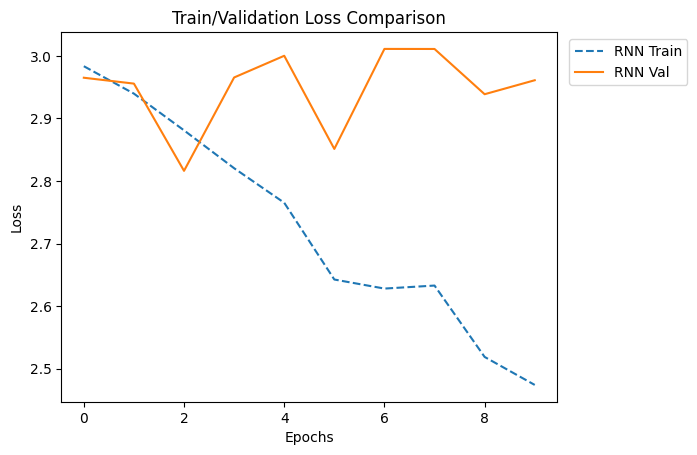

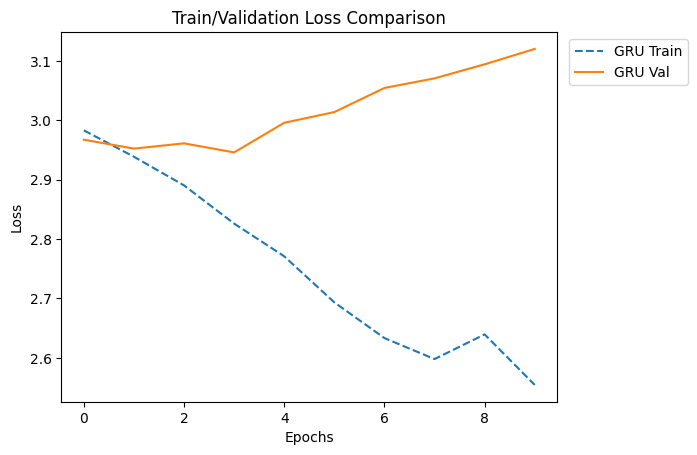

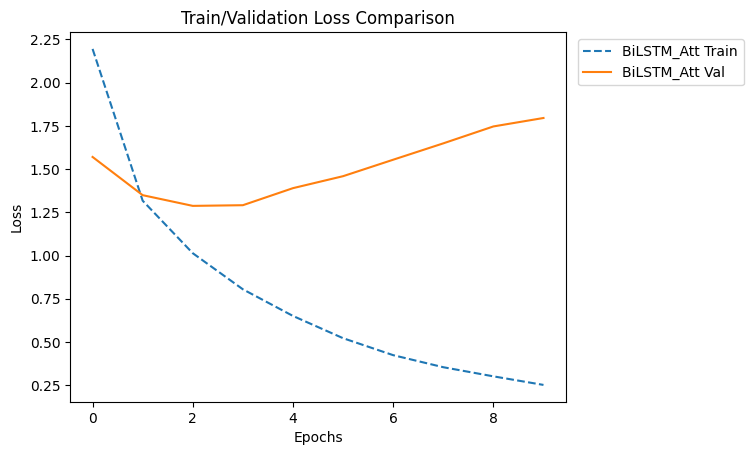

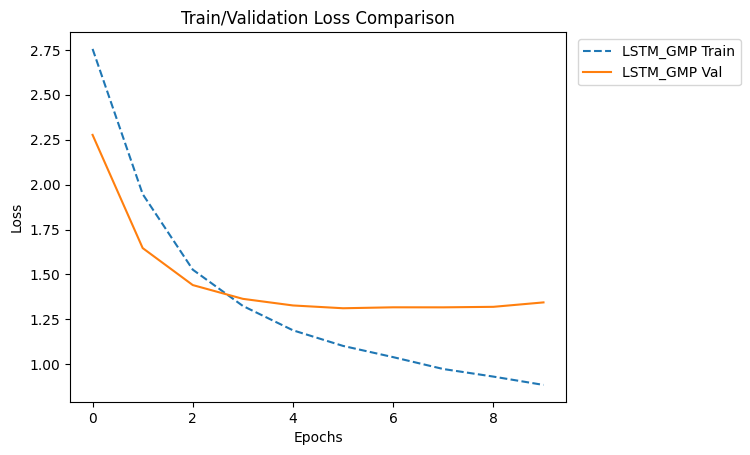

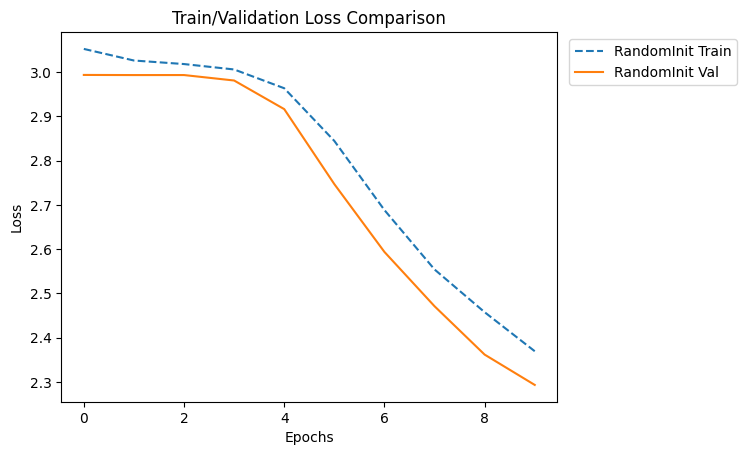

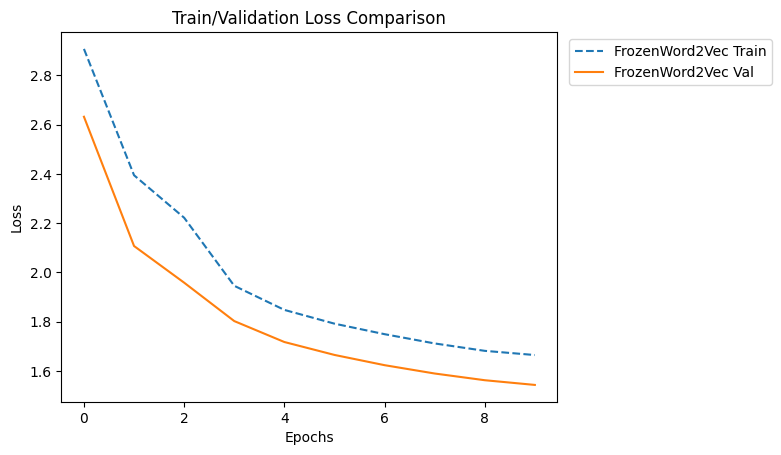

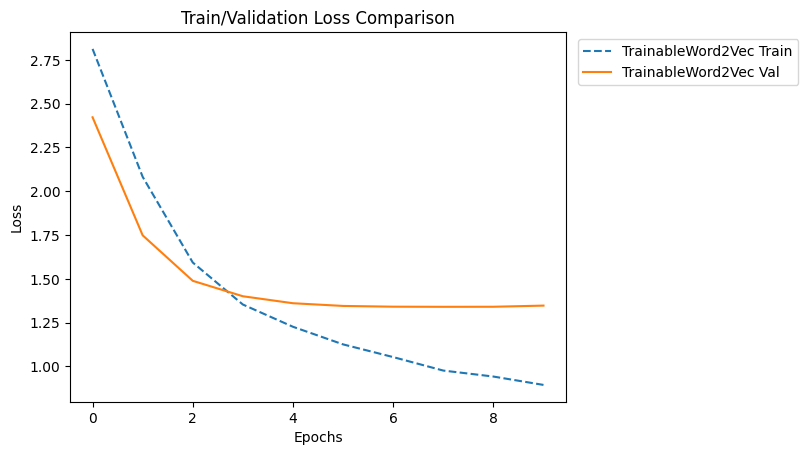

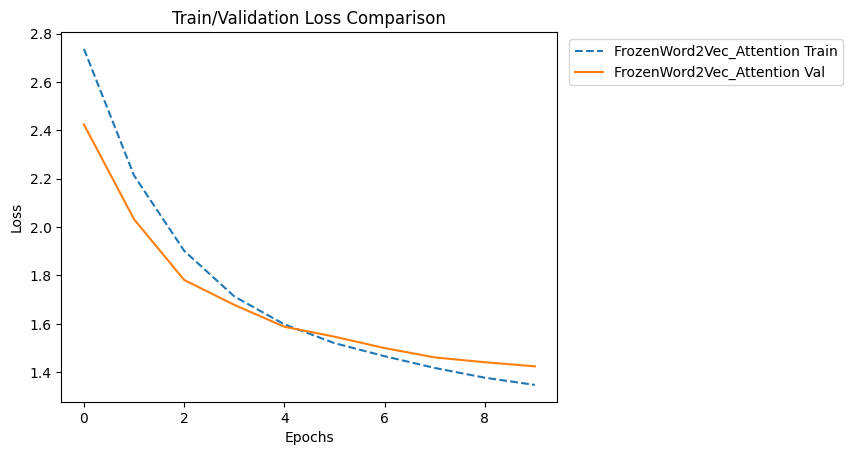

In [31]:
# Plot losses per model
for name in models:
    plt.plot(results[name]['train_loss'], linestyle='--', label=f'{name} Train')
    plt.plot(results[name]['val_loss'], label=f'{name} Val')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train/Validation Loss Comparison')
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.show()